In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Capacity Expansion Results

## Read in OSeMOSYS Results

In [3]:
annual_emissions = pd.read_csv('./Model/results/AnnualEmissions.csv')
capital_investments = pd.read_csv('./Model/results/CapitalInvestment.csv')
new_capacity = pd.read_csv('./Model/results/NewCapacity.csv')
demand = pd.read_csv('./Model/results/Demand.csv')
production_annual = pd.read_csv('./Model/results/ProductionByTechnologyAnnual.csv')
total_capacity = pd.read_csv('./Model/results/TotalCapacityAnnual.csv')

## Filter and Aggregate Results

In [4]:
capital_investments = capital_investments.loc[capital_investments['TECHNOLOGY'].isin(['HYDRO'])].reset_index(drop=True)
new_capacity = new_capacity.loc[new_capacity['TECHNOLOGY'].isin(['HYDRO', 'GAS', 'COAL'])].reset_index(drop=True)
production_annual = production_annual.loc[production_annual ['TECHNOLOGY'].isin(['HYDRO'])].reset_index(drop=True)
total_capacity = total_capacity.loc[total_capacity['TECHNOLOGY'].isin(['HYDRO'])].reset_index(drop=True)
demand = demand.groupby(by=['YEAR','FUEL','REGION']).sum().reset_index()

/tmp/ipykernel_21085/3492841060.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  demand = demand.groupby(by=['YEAR','FUEL','REGION']).sum().reset_index()


## Plot Results

### Installed Capacity 

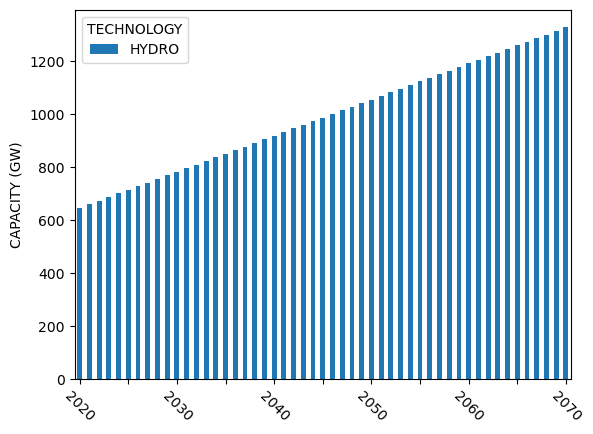

In [6]:
total_capacity_2 = total_capacity.pivot(index='YEAR',columns='TECHNOLOGY',values='VALUE')

ax = total_capacity_2.plot.bar( 
    stacked=True,
    legend='reverse',
    color=['tab:blue']
)

ax.set_ylabel('CAPACITY (GW)')
ax.set_xlabel('')
plt.locator_params(axis='x', nbins=11)
plt.xticks(rotation = -45)

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

### Electricity Generation

In [7]:
def add_legend_line(legend):
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(mlines.Line2D([],[],color='k'))
    labels.append("Demand")
    for h,l in enumerate(labels):
        if l == 'VALUE':
            labels.remove(l)
            del handles[h]

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())

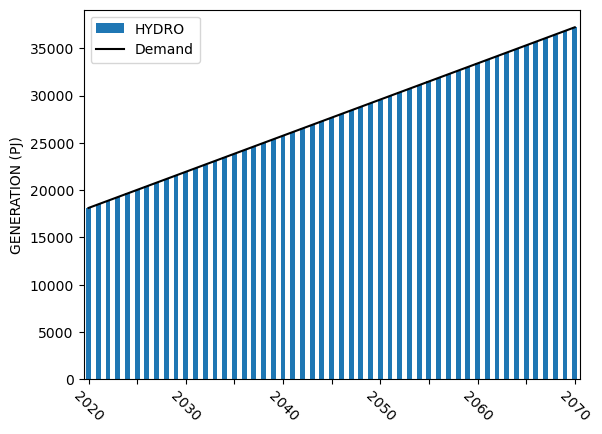

In [9]:
production_annual_2 = production_annual.pivot(index='YEAR',columns='TECHNOLOGY',values='VALUE')

ax = production_annual_2.plot.bar( 
    stacked=True,
    legend='reverse',
    color=['tab:blue']
)

xticks = ax.get_xticks()

demand['VALUE'].plot(
    x=xticks,
    ax=ax,
    color='k')

ax.set_ylabel('GENERATION (PJ)')
ax.set_xlabel('')
plt.locator_params(axis='x', nbins=11)
plt.xticks(rotation = -45)

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False) 

legend = ax.legend()
add_legend_line(legend)

### Capital Investments 

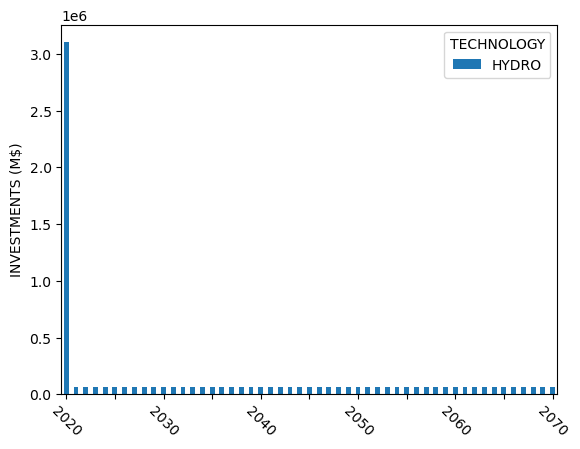

In [11]:
capital_investments_2 = capital_investments.pivot(index='YEAR',columns='TECHNOLOGY',values='VALUE')

ax = capital_investments_2.plot.bar( 
    stacked=True,
    legend='reverse',
    color=['tab:blue']
)

ax.set_ylabel('INVESTMENTS (M$)')
ax.set_xlabel('')
plt.locator_params(axis='x', nbins=11)
plt.xticks(rotation = -45)

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False) 

# GSA Results

## Read In GSA Results
SALib dones not have fuctionality to compare results from multiple GSA runs on a single graph. Therefore, we replicate their plotting functions here which allow us to compare results across multiple GSA runs. 

### Model one without demand 

In [17]:
model_1 = pd.read_csv('./GSA/No_Demand/Results/SA_objective.csv')
model_1.columns.values[0]='names'
# Row of zeros added for consistency when merging dataframes
model_1 = pd.concat([model_1,pd.DataFrame([['Demand',0,0,0,0]], columns=model_1.columns)])
model_1['model'] = 'Model 1'

### Model one with demand 

In [18]:
model_2 = pd.read_csv('./GSA/With_Demand/Results/SA_objective.csv')
model_2.columns.values[0]='names'
model_2['model'] = 'Model 2'

### Append results

In [29]:
model = pd.concat([model_1, model_2])
model = model.set_index('model')

m1 = model.loc[model.index == 'Model 1'].copy()
m2 = model.loc[model.index == 'Model 2'].copy()

name_mapper = {
        'capital':'Capital Cost',
        'fixed':'Fixed Cost',
        'Demand':'Demand'
    }

for mdf in [m1, m2]:
    mdf['names'] = mdf['names'].map(name_mapper)


## Plot Results 

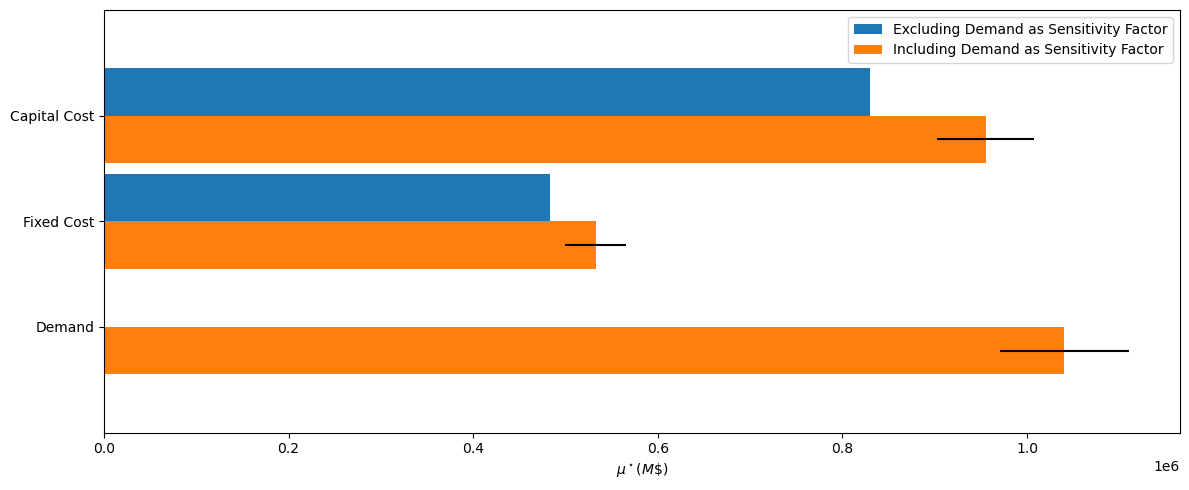

In [32]:
labels = list(m1['names'].unique())
# labels = labels
m1_mu_star = m1['mu_star'].to_list()
m1_mu_star.reverse()
m2_mu_star = m2['mu_star'].to_list()
m2_mu_star.reverse()

m1_mu_star_conf = m1['mu_star_conf'].to_list()
m1_mu_star_conf.reverse()
m2_mu_star_conf = m2['mu_star_conf'].to_list()
m2_mu_star_conf.reverse()

y = np.arange(len(labels))
height = 0.45

fig, ax = plt.subplots(figsize=(12,5))
m1_plt = ax.barh(
    y = y + height/2,
    width=m1_mu_star,
    height=height,
    xerr=m1_mu_star_conf,
    align="center",
    ecolor="black",
    label='Excluding Demand as Sensitivity Factor'
)
m2_plt = ax.barh(
    y = y - height/2,
    width=m2_mu_star,
    height=height,
    xerr=m2_mu_star_conf,
    align="center",
    ecolor="black",
    label='Including Demand as Sensitivity Factor'
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(r"$\mu^\star$")
ax.legend(fontsize='medium', loc='upper right')
y_pos = np.arange(len(m1_mu_star))
ax.set_yticks(y_pos)
lables = labels.reverse()
ax.set_yticklabels(labels)
ax.set_xlabel(r"$\mu^\star (M\$)$")

ax.set_ylim(min(y_pos) - 1, max(y_pos) + 1)

fig.tight_layout()